In [1]:
# データ準備
import pandas as pd
df = pd.read_csv('./breast-cancer-wisconsin-data/data.csv',skiprows=1, header=None)
from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values
y = df.loc[:,1].values
le = LabelEncoder()
y = le.fit_transform(y)
from sklearn.model_selection import train_test_split
X_train,X_test,y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=1)

#パイプライン準備
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#param grid
param_range=[0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]
param_grid=[{'clf__C':param_range,'clf__kernel':['linear']},
            {'clf__C':param_range,'clf__gamma':param_range,'clf__kernel':['rbf']}]

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
pipe_svc = Pipeline([('scl',StandardScaler()), ('clf', SVC(random_state=1))])

from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train,y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test,y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


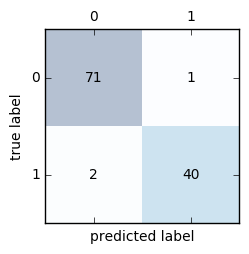

In [3]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(confmat, cmap=plt.cm.Blues,alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,y=i, s=confmat[i,j], va='center',ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

In [4]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score,f1_score

print('Precision: %.3f' % precision_score(y_true=y_test,y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test,y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test,y_pred=y_pred))

Precision: 0.976
Recall: 0.952
F1: 0.964


In [8]:
from sklearn.metrics import make_scorer, f1_score

#クラス０を陽性として扱った場合のF1値
scorer = make_scorer(f1_score, pos_label=0)
gs = GridSearchCV(estimator=pipe_svc,param_grid=param_grid,scoring=scorer, cv=10)
gs = gs.fit(X_train,y_train)
gs.best_score_

0.98279866820763184

## ROC

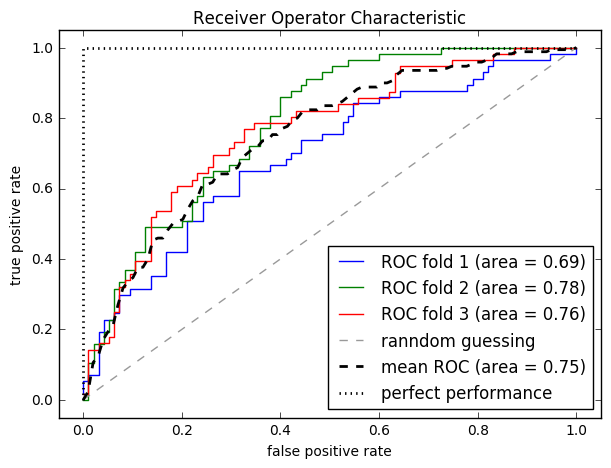

In [20]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
import numpy as np

pipe_lr = Pipeline([('scl', StandardScaler()),('pca', PCA(n_components=2)),('clf', LogisticRegression(penalty='l2', random_state=0, C=100.0))])

X_train2 = X_train[:, [4,14]]
cv = StratifiedKFold(y_train, n_folds=3, random_state=1)
flg = plt.figure(figsize=(7,5))
mean_tpr= 0.0
mean_fpr = np.linspace(0,1,100)
all_tpr = []

for i , (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:,1],pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))
    
plt.plot([0,1],[0,1],linestyle='--',color=(0.6,0.6,0.6),label='ranndom guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr,mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',label='mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.plot([0,0,1],[0,1,1],lw=2,linestyle=':',color='black', label='perfect performance')

plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc='lower right')
plt.show()

In [23]:
pipe_lr = pipe_lr.fit(X_train2, y_train)
y_pred2 = pipe_lr.predict(X_test[:,[4,14]])
from sklearn.metrics import roc_auc_score,accuracy_score

print('ROC AUC: %.3f' % roc_auc_score(y_true=y_test, y_score=y_pred2))
print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred2))

ROC AUC: 0.662
Accuracy: 0.711


In [ ]:
pre_scorer = make_scorer(score_func=precision_score,
                        pos_label=1,
                        greater_is_better=True,
                        average='micro')